# Topic Modeling the Headline News with Latent Dirichilet Allocation

## Package Denpendencies

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE


[nltk_data] Downloading package stopwords to /Users/eric/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/eric/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Configurations



In [2]:
file_path = "./abcnews-date-text.csv"

sample_num = 1164946
topic_num = 34

stemmer = SnowballStemmer(language='english')
stop_words = set(stopwords.words('english'))
punctuations = string.punctuation

# Testing
print(word_tokenize("What is your name"), 'is' in stop_words)
print(stemmer.stem("difference"), stemmer.stem("justify"), stemmer.stem("running"))

['What', 'is', 'your', 'name'] True
differ justifi run


## Data Preprepartion

### Load and display the data

In [3]:
df = data = pd.read_csv(file_path, skiprows=[i for i in range(1,sample_num)])
print(df.head(10))

   publish_date                                      headline_text
0      20190517  nrl panthers warriors broncos roosters scorece...
1      20190517              nrl responds to jack de belin verdict
2      20190517  nurse sentenced to community service over botc...
3      20190517  olympic cyclist jack bobridge found guilty of ...
4      20190517  one hour workers one hour employment jobs unem...
5      20190517    one punch attacker sentenced over act caught on
6      20190517         one punch attacker sentenced to five years
7      20190517            paul keating reflects hawke era reforms
8      20190517  people who own guns illegally cause the gun crime
9      20190517  perth father admits sleepover sexual abuse chi...


### Display and clear the repetitions if any


In [4]:
df[df['headline_text'].duplicated(keep=False)]\
      .sort_values('headline_text').head(10)
df_norep = df.drop_duplicates('headline_text')

### Pick up sample_num (defined at [Configurations](#scrollTo=SHRdUgeGDXEH&line=1&uniqifier=1)) of headlines 

In [5]:
# data = df_norep.sample(n=sample_num, axis=0)
text_data = df['headline_text'].copy(deep=True)
text_data.head(10)

0    nrl panthers warriors broncos roosters scorece...
1                nrl responds to jack de belin verdict
2    nurse sentenced to community service over botc...
3    olympic cyclist jack bobridge found guilty of ...
4    one hour workers one hour employment jobs unem...
5      one punch attacker sentenced over act caught on
6           one punch attacker sentenced to five years
7              paul keating reflects hawke era reforms
8    people who own guns illegally cause the gun crime
9    perth father admits sleepover sexual abuse chi...
Name: headline_text, dtype: object

### Clear the stop words, replace the words in headlines with their stem word, and clear the punctiations.

In [6]:
def processor(text):
    # for punctuation in punctuations:
    #     text = text.replace(punctuation, '')
    # text = text.lower()
    text = [word for word in word_tokenize(text) if not word in stop_words]
    text = [stemmer.stem(word) for word in text]
    return " ".join(text)

# Test
processor("This is a good beginning. So be happy.")

'this good begin . so happi .'

In [7]:
from tqdm import tqdm

for idx in tqdm(data.index):
    text_data[idx] = processor(text_data[idx])

text_data.head(10)

100%|██████████| 61313/61313 [00:05<00:00, 10375.80it/s]


0        nrl panther warrior bronco rooster scorecentr
1                    nrl respond jack de belin verdict
2    nurs sentenc communiti servic botch breast sur...
3    olymp cyclist jack bobridg found guilti drug deal
4         one hour worker one hour employ job unemploy
5                  one punch attack sentenc act caught
6                   one punch attack sentenc five year
7                    paul keat reflect hawk era reform
8                       peopl gun illeg caus gun crime
9    perth father admit sleepov sexual abus child p...
Name: headline_text, dtype: object

### Calculate the Count Vector and Tfidf Vector

In [8]:
CountVectorizer().fit_transform(text_data).shape

(61313, 22772)

In [9]:
vect = TfidfVectorizer(max_features=8000)
X = vect.fit_transform(text_data).toarray()
tfidf_features = vect.get_feature_names_out()
X = pd.DataFrame(X, columns=tfidf_features)
X

,06,10,100,1000,10000,100000,100k,100th,103,104,...,zillmer,zimbabw,zimmerman,zoe,zombi,zone,zoo,zoom,zuckerberg,zverev
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modeling

### Build and fit the NMF model

In [10]:
nmf_model = NMF(n_components=topic_num, init="nndsvd", random_state=1)
nmf_features = nmf_model.fit_transform(X)

violation: 1.0
violation: 0.2858264106661804
violation: 0.16019480272452633
violation: 0.092933787283194
violation: 0.06265000580162251
violation: 0.04569460698167639
violation: 0.035939055144892526
violation: 0.028822281661097612
violation: 0.023268134527165592
violation: 0.01874420806281289
violation: 0.01509577213835152
violation: 0.012253464919684624
violation: 0.010215381845670071
violation: 0.008681417051227444
violation: 0.007425617511922295
violation: 0.00645244803301767
violation: 0.005744044013039112
violation: 0.005148326584230717
violation: 0.004694308179184756
violation: 0.00434582102687215
violation: 0.00405256147236316
violation: 0.0038202341806432725
violation: 0.0036150485388419407
violation: 0.0034161666609352466
violation: 0.003213204658148033
violation: 0.0030169732974287843
violation: 0.00282236889007661
violation: 0.00261537747432547
violation: 0.002395288153031481
violation: 0.0021940380612694545
violation: 0.002149236624366359
violation: 0.00215758433738082
viol

/Users/eric/miniforge3/envs/NLP/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


### Build and fit the K-Means model

In [11]:
km_model = KMeans(topic_num, init="k-means++", random_state=1)
km_model.fit(nmf_features)

Initialization complete
Iteration 0, inertia 89.62294051569509
Iteration 1, inertia 75.9259980768696
Iteration 2, inertia 75.24410332871103
Iteration 3, inertia 74.89782076488717
Iteration 4, inertia 74.8078255470866
Iteration 5, inertia 74.77188579070655
Iteration 6, inertia 74.69710290716847
Iteration 7, inertia 74.5907267068653
Iteration 8, inertia 74.49645378650644
Iteration 9, inertia 74.31236502797012
Iteration 10, inertia 73.71621573022193
Iteration 11, inertia 72.82330128760572
Iteration 12, inertia 72.65451082754579
Iteration 13, inertia 72.64426387956654
Iteration 14, inertia 72.64263021309671
Iteration 15, inertia 72.642415486432
Iteration 16, inertia 72.64236303088094
Iteration 17, inertia 72.64235020997438
Converged at iteration 17: strict convergence.
Initialization complete
Iteration 0, inertia 86.49438778089348
Iteration 1, inertia 69.84192331991615
Iteration 2, inertia 68.94004406873299
Iteration 3, inertia 68.67492589686914
Iteration 4, inertia 68.36421748266456
Itera

KMeans(n_clusters=34, random_state=1, verbose=1)

### Display the outputs

In [12]:
# Display the output features
nmf_features

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.09884683e-03, 1.54321752e-02, 0.00000000e+00],
       [1.36872563e-05, 0.00000000e+00, 0.00000000e+00, ...,
        4.11334938e-03, 8.17576972e-03, 0.00000000e+00],
       [7.46513441e-04, 1.56262519e-05, 1.14945317e-03, ...,
        0.00000000e+00, 2.26342190e-03, 1.12273818e-03],
       ...,
       [1.84377144e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.98747704e-04, 0.00000000e+00, 5.50374762e-02, ...,
        1.86710957e-04, 2.09940112e-03, 0.00000000e+00],
       [3.80104698e-03, 3.10357553e-04, 4.60877219e-03, ...,
        0.00000000e+00, 2.35229690e-03, 0.00000000e+00]])

In [13]:
# Build the word(token) matrix as a Dataframe
components_df = pd.DataFrame(nmf_model.inverse_transform(km_model.cluster_centers_), 
                             columns=vect.get_feature_names_out())
components_df

,06,10,100,1000,10000,100000,100k,100th,103,104,...,zillmer,zimbabw,zimmerman,zoe,zombi,zone,zoo,zoom,zuckerberg,zverev
0,5.029251e-05,8.016223e-03,6.416911e-03,0.000632,3.507705e-04,2.657460e-05,4.172875e-05,3.278981e-04,4.447108e-04,4.371453e-05,...,1.044998e-04,6.560437e-05,6.066123e-06,2.166326e-04,5.568147e-04,1.775042e-04,2.309198e-04,2.539668e-05,1.531953e-05,2.371658e-05
1,1.691564e-06,2.618700e-05,4.630738e-07,0.000002,1.106784e-08,6.289477e-08,1.527530e-08,5.785918e-08,1.997990e-09,2.449789e-07,...,5.361846e-08,3.461707e-08,9.226084e-08,7.227972e-08,2.036200e-07,6.724024e-07,5.229884e-07,6.945238e-08,1.196877e-08,3.285316e-08
2,3.904691e-04,1.518547e-03,1.349056e-03,0.000978,3.464887e-04,6.430830e-04,2.687535e-04,1.043533e-04,1.887543e-05,1.670469e-04,...,1.590838e-05,5.048013e-04,4.727257e-06,1.044088e-04,7.793052e-06,8.309720e-04,8.775083e-04,3.985716e-04,8.964900e-06,1.795200e-05
3,9.110044e-06,6.850421e-04,3.458748e-04,0.000187,2.811031e-05,1.770579e-04,5.538444e-05,5.310244e-05,4.266714e-05,2.868230e-05,...,6.299156e-05,5.069456e-05,7.229140e-06,1.686036e-05,5.392362e-05,1.348641e-03,2.987099e-04,6.334603e-05,4.526661e-05,1.548878e-04
4,4.924714e-06,3.495232e-03,9.845660e-04,0.000010,5.654902e-07,2.778930e-06,2.643871e-06,6.256834e-07,1.034163e-06,3.125164e-07,...,3.879021e-06,2.358161e-07,2.439203e-07,6.719535e-07,1.297788e-06,2.629917e-05,1.117266e-06,1.454617e-06,1.394769e-07,7.339091e-07
5,5.292924e-06,5.783223e-04,3.494426e-04,0.000108,2.143550e-05,3.712187e-05,5.419202e-05,4.746564e-04,5.020992e-05,7.241958e-05,...,9.007362e-05,2.589853e-05,4.737742e-06,2.319999e-05,5.473084e-05,1.568315e-03,1.331147e-04,4.151690e-05,1.176404e-05,9.968479e-05
6,9.092208e-06,7.412844e-04,1.444881e-03,0.000114,3.154138e-05,8.776133e-05,4.906771e-05,1.999904e-04,5.404772e-05,3.425692e-05,...,7.808486e-05,5.007602e-05,5.214254e-06,2.200774e-04,6.392411e-05,3.987100e-04,5.339901e-04,7.400997e-05,2.782047e-05,4.703801e-05
7,2.980439e-05,4.186789e-04,2.968814e-05,0.000018,7.294189e-06,5.137488e-06,2.724227e-06,4.044665e-06,4.645974e-06,3.588235e-06,...,2.339256e-06,4.489325e-06,9.304673e-04,6.752039e-05,6.962179e-04,2.949733e-05,8.268526e-06,9.422851e-04,3.036122e-04,3.080707e-06
8,1.235739e-05,4.176255e-04,3.226058e-04,0.000238,2.492743e-05,5.076939e-05,3.495031e-05,4.507061e-05,3.919339e-05,3.055585e-05,...,2.233104e-05,3.922006e-05,1.392877e-05,3.829901e-05,6.425667e-05,2.178216e-04,1.549399e-04,6.215984e-05,5.149304e-05,4.477171e-05
9,2.372085e-05,3.100784e-03,3.550248e-04,0.000123,2.696662e-05,3.648092e-05,6.196645e-05,5.112934e-05,4.931812e-05,2.192401e-05,...,1.761842e-04,3.130355e-05,7.808920e-06,1.517257e-05,4.944006e-05,4.335868e-04,1.036433e-04,4.961451e-05,8.466301e-06,1.986812e-05


## Display the Modelling effects

### The 10 words with the highest values of each topic

In [14]:
for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print("Topic {:>2}: ".format(topic), end="")
    top_words = tmp.nlargest(10)
    for i in range(10):
        print("{:>11}*{:>3.4f}".format(top_words.index[i], top_words[i]), end=" ")
    print()

Topic  0:        year*0.1693       crash*0.0518         one*0.0509         two*0.0503        kill*0.0502      school*0.0468         old*0.0451         day*0.0366         car*0.0233     student*0.0227 
Topic  1:      financ*0.5047        alan*0.4783      kohler*0.4768    thursday*0.1255   wednesday*0.1231     tuesday*0.1186      monday*0.1135      friday*0.0562      lasker*0.0458     phillip*0.0449 
Topic  2:        live*0.3568       covid*0.3149          19*0.2841   australia*0.2515        news*0.2109 coronavirus*0.1840       updat*0.1666      latest*0.1594     covid19*0.1228    victoria*0.0683 
Topic  3:      border*0.1723          wa*0.1277 coronavirus*0.0537      closur*0.0410        open*0.0407          sa*0.0362    restrict*0.0302         nsw*0.0275      reopen*0.0259      travel*0.0247 
Topic  4:         abc*0.5055        news*0.5024       stori*0.4470         top*0.4365        quiz*0.0394     headlin*0.0234      latest*0.0189       rural*0.0143       brief*0.0137      sydney*0.0

### Count number of headlines be categorized into each topic

Text(0, 0.5, 'Number of headlines')

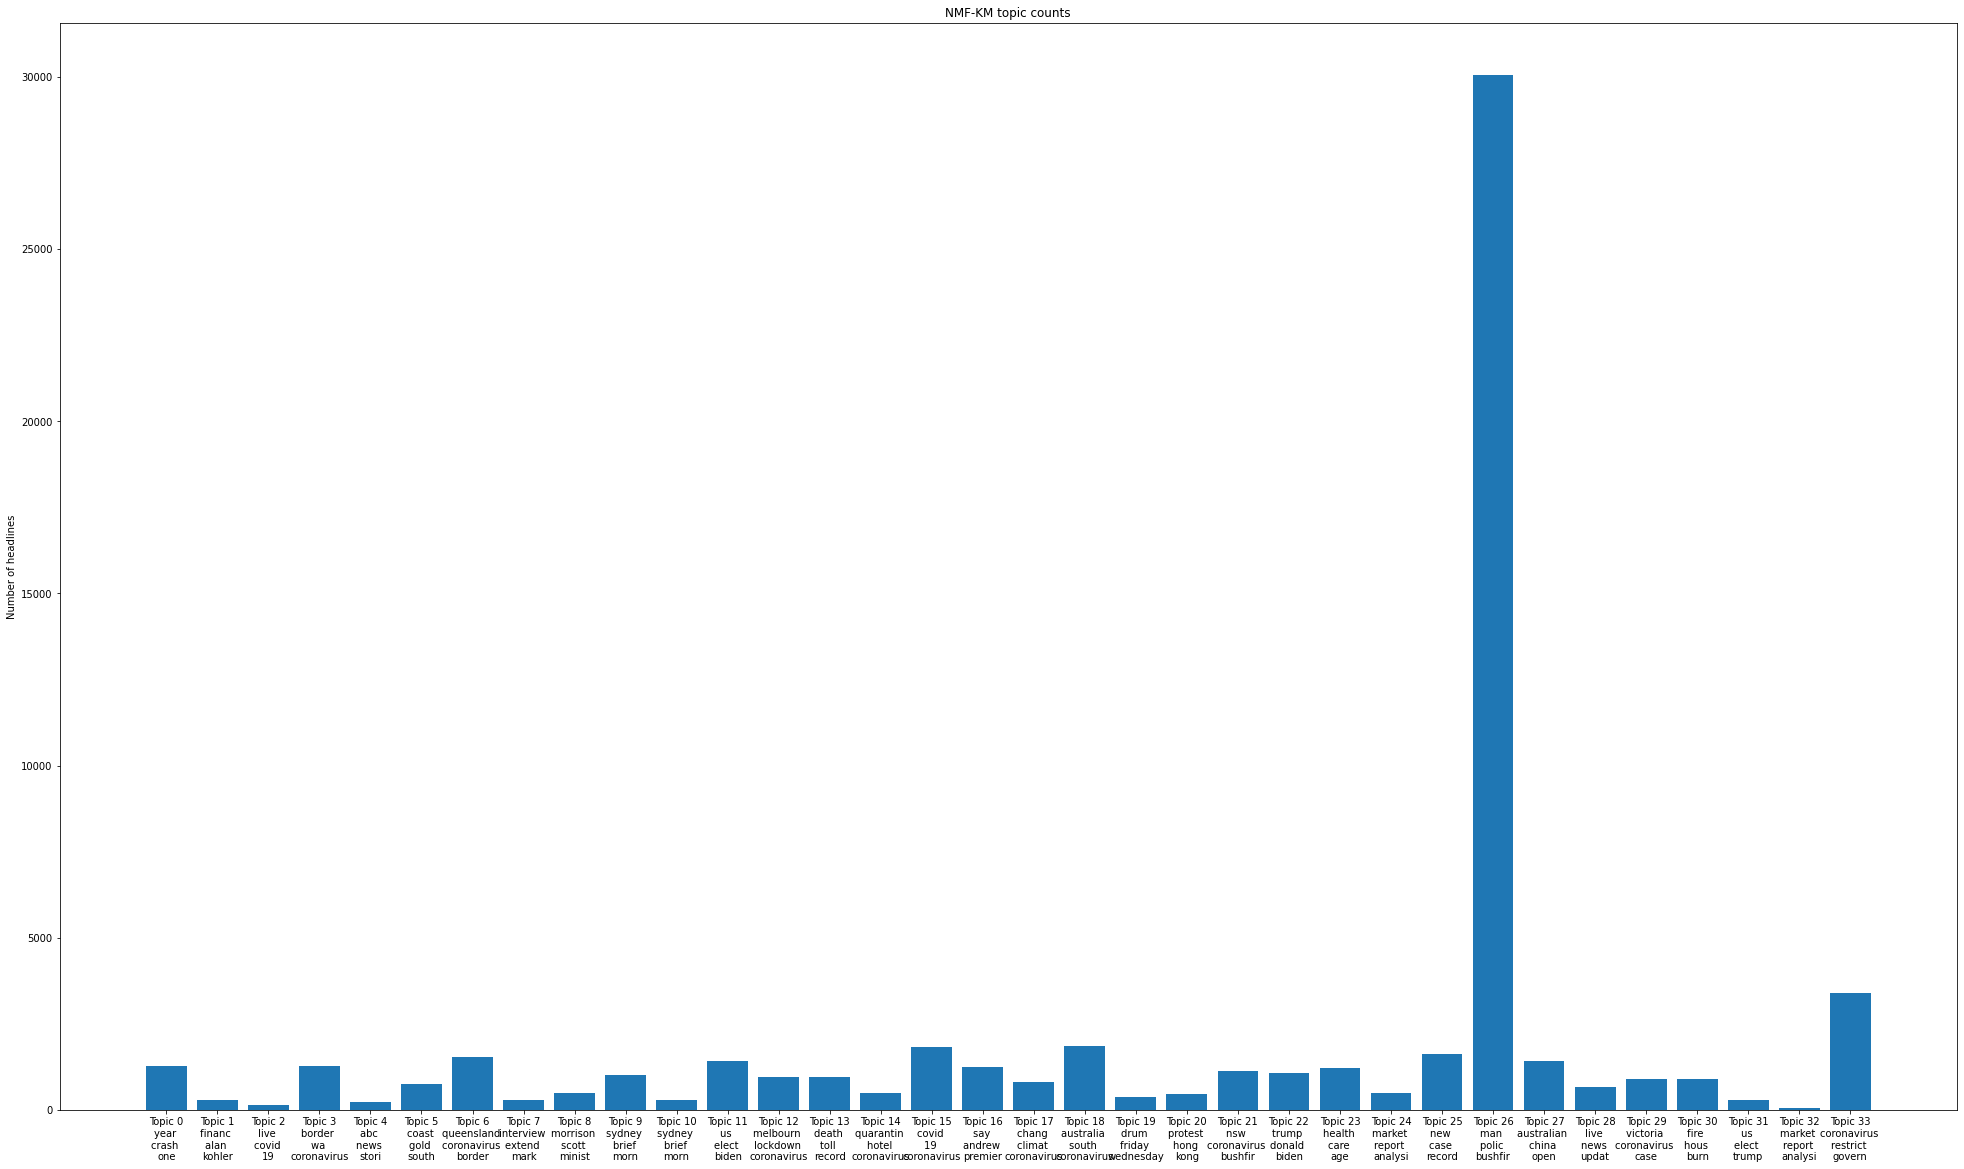

In [15]:
labels = []
counts = [0]*topic_num
# Calculate the 3 words(tokens) with the highest value as the x tick label
for topic in range(topic_num):
    top_words = components_df.iloc[topic].nlargest(3)
    labels.append("Topic {}\n{} \n{} \n{}".format(topic, top_words.index[0],
            top_words.index[1],top_words.index[2]))

# Calculate the number of headlines in each topic
for idx in range(nmf_features.shape[0]):
    counts[km_model.labels_[idx]] += 1

_, ax = plt.subplots(figsize=(topic_num, 20))
ax.bar(range(topic_num), counts)
ax.set_xticks(range(topic_num))
ax.set_xticklabels(labels)
ax.set_title('NMF-KM topic counts')
ax.set_ylabel('Number of headlines')


In [16]:
km_model.labels_
for i in range(topic_num):
    counter = 0
    for j in range(km_model.labels_.shape[0]):
        if km_model.labels_[j] == i:
            counter += 1
    print(i,':',counter, end=", ")
print()

0 : 1270, 1 : 278, 2 : 147, 3 : 1276, 4 : 225, 5 : 763, 6 : 1550, 7 : 291, 8 : 487, 9 : 1010, 10 : 292, 11 : 1428, 12 : 946, 13 : 961, 14 : 491, 15 : 1827, 16 : 1242, 17 : 820, 18 : 1872, 19 : 384, 20 : 479, 21 : 1138, 22 : 1077, 23 : 1228, 24 : 500, 25 : 1628, 26 : 30066, 27 : 1410, 28 : 682, 29 : 902, 30 : 894, 31 : 277, 32 : 68, 33 : 3404, 


### Draw the t-SNE Clustering of the Topics

In [17]:
# Take random sample of the topics to aviod too many overlapped plots in figure
sampled_feat_idx = np.random.choice(
    np.array([i for i in range(nmf_features.shape[0])]), size=20000, replace=True)

tsne_model = TSNE(n_components=2, perplexity=50, learning_rate=100, random_state=1, 
                        n_iter=2500, verbose=1, init='random', angle=0.75)
tsne_vectors = tsne_model.fit_transform(nmf_features[sampled_feat_idx])

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.003s...
[t-SNE] Computed neighbors for 20000 samples in 5.036s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sa

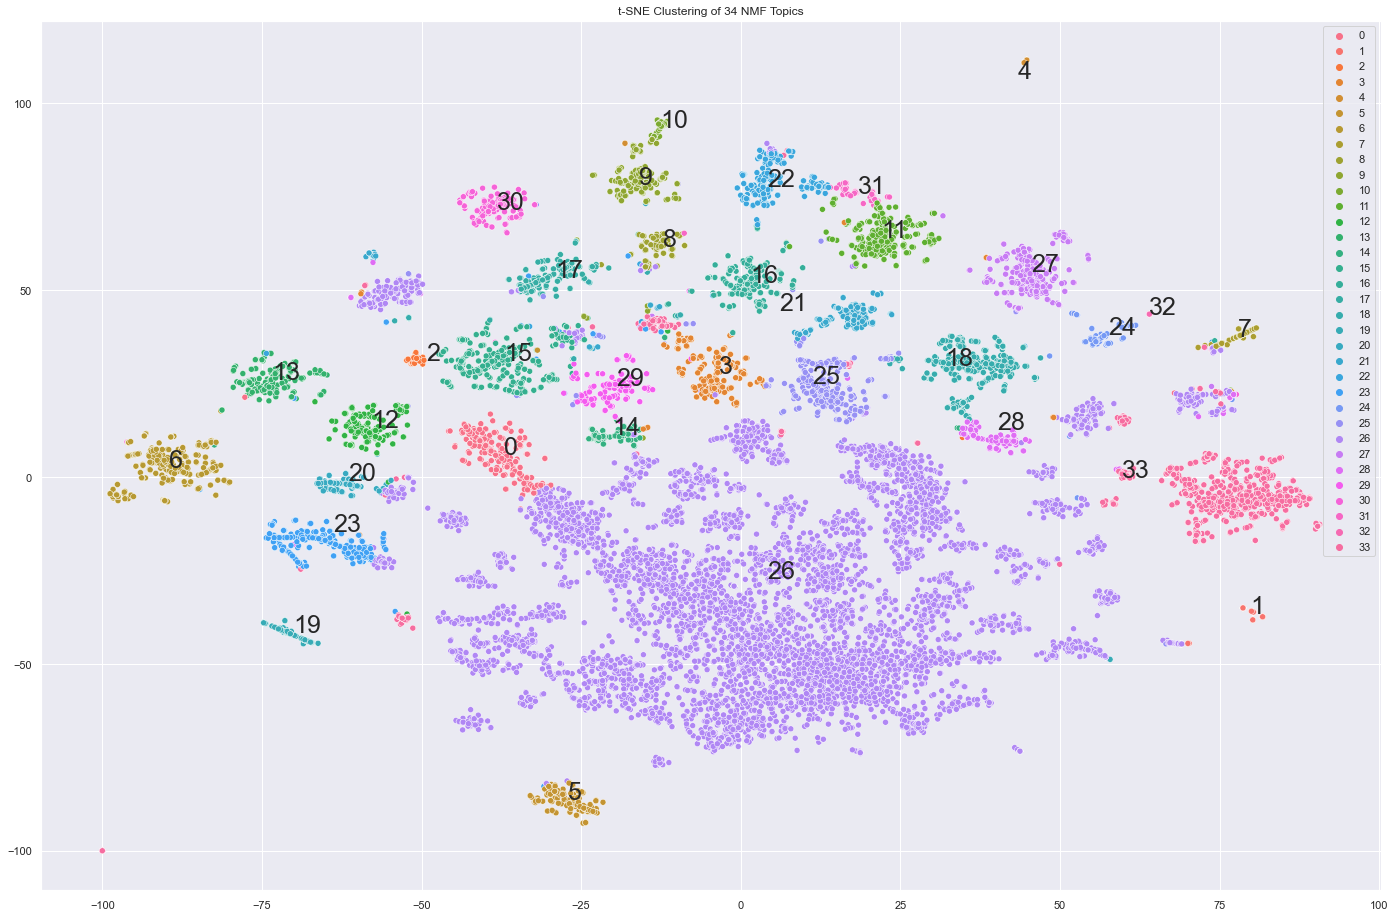

In [18]:
# Assign a label to each topic and reformat the tsne feature matrix to calculate the mean
tsne_label = [str(i) for i in range(topic_num)]
tsne_vec_re = [[[], []] for i in range(topic_num)]
for (idx, feat_idx) in enumerate(sampled_feat_idx):
    topic = km_model.labels_[feat_idx]
    tsne_label.append("{}".format(topic))
    tsne_vec_re[topic][0].append(tsne_vectors[idx][0])
    tsne_vec_re[topic][1].append(tsne_vectors[idx][1])

# Use a placeholder(add a outlier (-100, -100) for each topic) 
# to make the label displayed in order
placeholder = np.array([[-100, -100]]*topic_num)
tsne_vectors_ = np.concatenate((placeholder, tsne_vectors), axis=0)
    
# Display the t-SNE plot
sns.set(rc={'figure.figsize':(24,16)})
plt.title("t-SNE Clustering of {} NMF Topics".format(topic_num))
sns.scatterplot(x = tsne_vectors_[:,0], y = tsne_vectors_[:,1],
                 hue=tsne_label, legend='full')

# Define a mean function of a list
def mean(x):
    return sum(x)/len(x)

# Put the topic text to the cluster, the position is the mean 
# vector of all headlines in the cluster
for topic in range(topic_num):
    (x, y) = mean(tsne_vec_re[topic][0]), mean(tsne_vec_re[topic][1])
    plt.text(x, y, tsne_label[topic], fontsize = 25)